In [1]:
## -- Set Device-Agnostic code --
import torch

if torch.cuda.is_available():
    get_ipython().run_line_magic('load_ext', 'cudf.pandas')
    get_ipython().run_line_magic('load_ext', 'cuml.accel')
else:
    pass

print(f"\nℹ️ Cuda available: {torch.cuda.is_available()}")


ℹ️ Cuda available: False


In [2]:
## -- IMPORT LIBRARIES --
import sys
import os
import gc

import joblib
import pickle

## -- DATA MANIPUALATION --
import numpy as np
import pandas as pd
import random

## -- VISUALISATION --
import shap
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from IPython.display import display, Image

## -- FUNCTIONAL TOOLS --
from time import time, sleep
from google.colab import files
from tqdm.notebook import tqdm
from itertools import combinations

## -- MACHINE LEARNING --
import sklearn
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split, KFold

import xgboost as xgb

import warnings

In [3]:
print(f"xbg version: {xgb.__version__}")
print(f"sklearn version: {sklearn.__version__}")
print(f"shap version: {shap.__version__}")

xbg version: 2.1.4
sklearn version: 1.5.2
shap version: 0.48.0


In [4]:
## --- GLOBAL SETTINGS --- ##
sklearn.set_config(transform_output="pandas")

warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 1000)
# pd.options.mode.copy_on_write = True
# plt.style.use("ggplot")

## -- Set Global Seed --
SEED = 42
def set_global_seed(seed = SEED):
    np.random.seed(seed)
    random.seed(seed)

set_global_seed()

COLOR = '\033[32m'
RESET = '\033[0m'

In [5]:
## -- Load Data --
PATH = "/kaggle/input/playground-series-s5e10/"
train= pd.read_csv(PATH+"train.csv", index_col='id') #.drop('id', axis=1)
test = pd.read_csv(PATH+"test.csv", index_col='id') #.drop('id', axis=1)
submit = pd.read_csv(PATH+"sample_submission.csv")

ORIG_PATH = "/kaggle/input/simulated-roads-accident-data/"
orig = pd.concat([pd.read_csv(ORIG_PATH+"synthetic_road_accidents_100k.csv"),
                  pd.read_csv(ORIG_PATH+"synthetic_road_accidents_10k.csv"),
                  pd.read_csv(ORIG_PATH+"synthetic_road_accidents_2k.csv")],
            ignore_index=True)

TARGET = "accident_risk"
NUMS = test.select_dtypes(include='number').columns.tolist()
CATS = test.select_dtypes(exclude='number').columns.tolist()
FEATURES = NUMS + CATS

for (name, df) in dict(Train=train, Test=test, Original=orig).items():
    print(f"{name} has shape: {df.shape}")

print(f"\nTotal Numerical: {len(NUMS)}")
print(f"Total Categorical: {len(CATS)}")

Train has shape: (517754, 13)
Test has shape: (172585, 12)
Original has shape: (112000, 13)

Total Numerical: 4
Total Categorical: 8


In [6]:
# ## -- Load Data --
# train= pd.read_csv("train.csv", index_col='id')
# test = pd.read_csv("test.csv", index_col='id')
# submit = pd.read_csv("sample_submission.csv")

# orig = pd.concat([pd.read_csv("synthetic_road_accidents_100k.csv"),
#                   pd.read_csv("synthetic_road_accidents_10k.csv"),
#                   pd.read_csv("synthetic_road_accidents_2k.csv")],
#             ignore_index=True)

# TARGET = "accident_risk"
# NUMS = test.select_dtypes(include='number').columns.tolist()
# CATS = test.select_dtypes(exclude='number').columns.tolist()
# FEATURES = NUMS + CATS

# for (name, df) in dict(Original=orig, Train=train, Test=test).items():
#     print(f"{name} shape: {df.shape}")

# print(f"\nTotal Numerical: {len(NUMS)}")
# print(f"Total Categorical: {len(CATS)}")

In [7]:
train.head()

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
id,,,,,,,,,,,,,
0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [8]:
## -- Unique value counts per dataset --
TRAIN_UNIQUE = {}
ORIGINAL_UNIQUE = {}
TEST_UNIQUE = {}

for col in test.columns:
    TRAIN_UNIQUE[col] = train[col].nunique()
    ORIGINAL_UNIQUE[col] = orig[col].nunique()
    TEST_UNIQUE[col] = test[col].nunique()

unique_counts_df = pd.concat(
        [pd.DataFrame(TRAIN_UNIQUE, index=['Train']),
         pd.DataFrame(ORIGINAL_UNIQUE, index=['Original']),
         pd.DataFrame(TEST_UNIQUE, index=['Test'])],
    )

unique_counts_df.style.background_gradient(cmap='Spectral')

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents
Train,3,4,261,5,3,3,2,2,3,2,2,8
Original,3,4,101,5,3,3,2,2,3,2,2,11
Test,3,4,195,5,3,3,2,2,3,2,2,8


### FEATURE ENGINEERING

In [9]:
## -- CREATE FEATURES -- ##
def create_features(train_df, test_df, orig_df):
    train = train_df.copy()
    test = test_df.copy()
    orig = orig_df.copy()

    ## -- meta feature --
    BINARY_COLS = [c for c in test.columns if test[c].nunique() == 2]
    for df in [train, test, orig]:
        base_risk = (
            0.3 * df["curvature"] +
            0.2 * (df["lighting"] == "night").astype(int) +
            0.1 * (df["weather"] != "clear").astype(int) +
            0.2 * (df["speed_limit"] >= 60).astype(int) +
            0.1 * (np.array(df["num_reported_accidents"]) > 2).astype(int)
                )
        df['meta'] = base_risk

        df['BINARY'] = 0
        for i in range(len(BINARY_COLS)):
            df['BINARY'] += df[BINARY_COLS[i]].astype(int) * (2**i)

    print(f"✅ 'meta' feature created!")
    print(f"✅ 'BINARY' feature created!")

    DIGITS = []
    for c in ['curvature', 'speed_limit']: # only features with > 1 digits
        for i in range(-3, 3):
            n = f"{c}_{i}"
            train[n] = ((train[c] * 10**i) % 10).astype("int8")
            test[n]  = ((test[c]  * 10**i) % 10).astype("int8")
            orig[n]  = ((orig[c]  * 10**i) % 10).astype("int8")
            if train[n].nunique()==1:
                train = train.drop([n], axis=1)
                test  = test.drop([n], axis=1)
                orig  = orig.drop([n], axis=1)
            else:
                DIGITS.append(n)
    print(f"✅  Digits extract features: {len(DIGITS)}")
    for col in DIGITS:
        print(f"{col}: {train[col].nunique()} unique values")

    ## -- FEATURE 1: Use original as features
    FEAT = [c for c in test.columns if c not in BINARY_COLS] # Exclude binned features
    print(f"Merging {len(FEAT)} features: ", end="")
    STATS = ['mean','count'] # ,'nunique','max','min',
    for c in FEAT:
        print(f"{c}, ", end="")
        tmp = orig.groupby(c)[TARGET].agg(STATS)
        tmp.columns = [f'OTE_{c}_{s.upper()}' for s in STATS]
        train = train.merge(tmp, on=c, how='left')
        test  = test.merge(tmp, on=c, how='left')
    print()

    BINS = []
    print(f"\nCreating bins... ", end="")
    for c in ['curvature', 'meta']: # <- add feature 1 after the other
        for b in [4, 10]:
            print(f"{c}_{b}, ", end="")
            b_n = f'{c}_bin_{b}'
            # Fit on train data and transform both train and test
            bins = np.linspace(train[c].min(), train[c].max(), b+1)
            train[b_n] = pd.cut(train[c], include_lowest=True, labels=False, bins=bins)
            test[b_n] = pd.cut(test[c], include_lowest=True, labels=False, bins=bins)
            BINS.append(b_n)
    print()
    print(f"✅ {len(BINS)} binned features created!")

    ## -- Factorize using combined data to ensure consistent mapping --
    BOOLS = train.select_dtypes(include=bool).columns
    for c in CATS:
        if c not in BOOLS:
            combined = pd.concat([train[c], test[c]], axis=0)
            combined = combined.factorize()[0]
            train[c] = combined[:len(train)].astype("int32")
            test[c]  = combined[len(train):].astype("int32")

    ## -- Polynomials --
    for df in [train, test]:
        df['curvature_sqrt'] = np.sqrt(df['curvature']) #Square-root
        df['curvature_squared'] = df['curvature'] ** 2 #Squared
        df['curvature_cubed'] = df['curvature'] ** 3 #Cubed
        df['curve-+-speed-+-light'] = df[['curvature', 'speed_limit', 'lighting']].sum(axis=1)
    print(f"✅ Polynomial features created!")

    ## -- Pairwise combinations --
    TE = []
    for n in [2]:
        for cols in tqdm(list(combinations(FEATURES+BINS+DIGITS+['BINARY'], n)), desc="Creating Pairwise"):
            name = '-|-'.join(sorted(cols))
            train[name] = train[cols[0]].astype(str) + '_' + train[cols[1]].astype(str)
            test[name] = test[cols[0]].astype(str) + '_' + test[cols[1]].astype(str)
            train[name] = train[name].astype('category')
            cat = train[name].cat
            train[name] = train[name].cat.codes
            test[name] = pd.Categorical(test[name], categories=cat.categories).codes
            TE.append(name)

    ## -- Triplewise combinations --
    TOP_PREDICTORS = ['curvature','lighting','speed_limit','weather','num_reported_accidents']
    for n in [3]:
        for cols in tqdm(list(combinations(TOP_PREDICTORS, n)), desc="Creating Triplewise"):
            nm = '-|-'.join(sorted(cols))
            train[nm] = train[cols[0]].astype(str) + '_' + \
                        train[cols[1]].astype(str) + '_' + \
                        train[cols[2]].astype(str)
            test[nm]  = test[cols[0]].astype(str) + '_' + \
                        test[cols[1]].astype(str) + '_' + \
                        test[cols[2]].astype(str)
            train[nm] = train[nm].astype('category')
            cat = train[nm].cat
            train[nm] = train[nm].cat.codes
            test[nm] = pd.Categorical(test[nm], categories=cat.categories).codes
            TE.append(nm)

    print(f"✅ Interations (TE) created: {len(TE)}")
    print(f"✅ Binned features (BINS): {len(BINS)}")
    print(f"{COLOR}{'='*50}")
    print(f"ℹ️ Feature Engineering Complete!")
    print(f"ℹ️ Total features: {len(test.columns)}")
    print(f"{'='*50}")

    return train, test, TE, BINS, DIGITS

In [10]:
train, test, TE, BINS, DIGITS = create_features(train, test, orig)

✅ 'meta' feature created!
✅ 'BINARY' feature created!
✅  Digits extract features: 5
curvature_0: 2 unique values
curvature_1: 10 unique values
curvature_2: 10 unique values
speed_limit_-1: 5 unique values
speed_limit_0: 2 unique values
Merging 15 features: road_type, num_lanes, curvature, speed_limit, lighting, weather, time_of_day, num_reported_accidents, meta, BINARY, curvature_0, curvature_1, curvature_2, speed_limit_-1, speed_limit_0, 

Creating bins... curvature_4, curvature_10, meta_4, meta_10, 
✅ 4 binned features created!
✅ Polynomial features created!


Creating Pairwise:   0%|          | 0/231 [00:00<?, ?it/s]

Creating Triplewise:   0%|          | 0/10 [00:00<?, ?it/s]

✅ Interations (TE) created: 241
✅ Binned features (BINS): 4
ℹ️ Feature Engineering Complete!
ℹ️ Total features: 298


In [11]:
display(train.head())
display(train.info())
train.shape, test.shape

,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk,meta,BINARY,curvature_0,curvature_1,curvature_2,speed_limit_-1,speed_limit_0,OTE_road_type_MEAN,OTE_road_type_COUNT,OTE_num_lanes_MEAN,OTE_num_lanes_COUNT,OTE_curvature_MEAN,OTE_curvature_COUNT,OTE_speed_limit_MEAN,OTE_speed_limit_COUNT,OTE_lighting_MEAN,OTE_lighting_COUNT,OTE_weather_MEAN,OTE_weather_COUNT,OTE_time_of_day_MEAN,OTE_time_of_day_COUNT,OTE_num_reported_accidents_MEAN,OTE_num_reported_accidents_COUNT,OTE_meta_MEAN,OTE_meta_COUNT,OTE_BINARY_MEAN,OTE_BINARY_COUNT,OTE_curvature_0_MEAN,OTE_curvature_0_COUNT,OTE_curvature_1_MEAN,OTE_curvature_1_COUNT,OTE_curvature_2_MEAN,OTE_curvature_2_COUNT,OTE_speed_limit_-1_MEAN,OTE_speed_limit_-1_COUNT,OTE_speed_limit_0_MEAN,OTE_speed_limit_0_COUNT,curvature_bin_4,curvature_bin_10,meta_bin_4,meta_bin_10,curvature_sqrt,curvature_squared,curvature_cubed,curve-+-speed-+-light,curvature-|-num_lanes,num_lanes-|-speed_limit,num_lanes-|-num_reported_accidents,num_lanes-|-road_type,lighting-|-num_lanes,num_lanes-|-weather,num_lanes-|-road_signs_present,num_lanes-|-public_road,num_lanes-|-time_of_day,holiday-|-num_lanes,num_lanes-|-school_season,curvature_bin_4-|-num_lanes,curvature_bin_10-|-num_lanes,meta_bin_4-|-num_lanes,meta_bin_10-|-num_lanes,curvature_0-|-num_lanes,curvature_1-|-num_lanes,curvature_2-|-num_lanes,num_lanes-|-speed_limit_-1,num_lanes-|-speed_limit_0,BINARY-|-num_lanes,curvature-|-speed_limit,curvature-|-num_reported_accidents,curvature-|-road_type,curvature-|-lighting,curvature-|-weather,curvature-|-road_signs_present,curvature-|-public_road,curvature-|-time_of_day,curvature-|-holiday,curvature-|-school_season,curvature-|-curvature_bin_4,curvature-|-curvature_bin_10,curvature-|-meta_bin_4,curvature-|-meta_bin_10,curvature-|-curvature_0,curvature-|-curvature_1,curvature-|-curvature_2,curvature-|-speed_limit_-1,curvature-|-speed_limit_0,BINARY-|-curvature,num_reported_accidents-|-speed_limit,road_type-|-speed_limit,lighting-|-speed_limit,speed_limit-|-weather,road_signs_present-|-speed_limit,public_road-|-speed_limit,speed_limit-|-time_of_day,holiday-|-speed_limit,school_season-|-speed_limit,curvature_bin_4-|-speed_limit,curvature_bin_10-|-speed_limit,meta_bin_4-|-speed_limit,meta_bin_10-|-speed_limit,curvature_0-|-speed_limit,curvature_1-|-speed_limit,curvature_2-|-speed_limit,speed_limit-|-speed_limit_-1,speed_limit-|-speed_limit_0,BINARY-|-speed_limit,num_reported_accidents-|-road_type,lighting-|-num_reported_accidents,num_reported_accidents-|-weather,num_reported_accidents-|-road_signs_present,num_reported_accidents-|-public_road,num_reported_accidents-|-time_of_day,holiday-|-num_reported_accidents,num_reported_accidents-|-school_season,curvature_bin_4-|-num_reported_accidents,curvature_bin_10-|-num_reported_accidents,meta_bin_4-|-num_reported_accidents,meta_bin_10-|-num_reported_accidents,curvature_0-|-num_reported_accidents,curvature_1-|-num_reported_accidents,curvature_2-|-num_reported_accidents,num_reported_accidents-|-speed_limit_-1,num_reported_accidents-|-speed_limit_0,BINARY-|-num_reported_accidents,lighting-|-road_type,road_type-|-weather,road_signs_present-|-road_type,public_road-|-road_type,road_type-|-time_of_day,holiday-|-road_type,road_type-|-school_season,curvature_bin_4-|-road_type,curvature_bin_10-|-road_type,meta_bin_4-|-road_type,meta_bin_10-|-road_type,curvature_0-|-road_type,curvature_1-|-road_type,curvature_2-|-road_type,road_type-|-speed_limit_-1,road_type-|-speed_limit_0,BINARY-|-road_type,lighting-|-weather,lighting-|-road_signs_present,lighting-|-public_road,lighting-|-time_of_day,holiday-|-lighting,lighting-|-school_season,curvature_bin_4-|-lighting,curvature_bin_10-|-lighting,lighting-|-meta_bin_4,lighting-|-meta_bin_10,curvature_0-|-lighting,curvature_1-|-lighting,curvature_2-|-lighting,lighting-|-speed_limit_-1,lighting-|-speed_limit_0,BINARY-|-lighting,road_signs_present-|-weat

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Columns: 299 entries, road_type to num_reported_accidents-|-speed_limit-|-weather
dtypes: bool(4), float64(24), int16(31), int32(4), int64(21), int8(215)
memory usage: 324.4 MB


None

((517754, 299), (172585, 298))

In [12]:
train[TE].shape

(517754, 241)

In [13]:
__ = [c for c in train.columns if train[c].nunique() < 2]
print(f"Produced {len(__)} single value features: {__}")
# train.drop(__, axis=1, inplace=True)
# test.drop(__, axis=1, inplace=True)
# print(f"Drop {len(__)} columns... Complete!")

Produced 0 single value features: []


### MODEL TRAINING

In [14]:
# %%capture
if torch.cuda.is_available():
    import cuml
    from cuml.preprocessing import TargetEncoder as cuTE
else:
    import category_encoders as ceTE

|---------------------------------
	Fold 1 #####


Target Encoding:   0%|          | 0/241 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16538
[100]	validation_0-rmse:0.10965
[200]	validation_0-rmse:0.07996
[300]	validation_0-rmse:0.06577
[400]	validation_0-rmse:0.05971
[500]	validation_0-rmse:0.05732
[600]	validation_0-rmse:0.05642
[700]	validation_0-rmse:0.05608
[800]	validation_0-rmse:0.05595
[900]	validation_0-rmse:0.05590
[1000]	validation_0-rmse:0.05588
[1100]	validation_0-rmse:0.05587
[1200]	validation_0-rmse:0.05587
[1300]	validation_0-rmse:0.05586
[1400]	validation_0-rmse:0.05586
[1500]	validation_0-rmse:0.05586
[1594]	validation_0-rmse:0.05587
	RMSE Score: 0.055863
|---------------------------------
	Fold 2 #####


Target Encoding:   0%|          | 0/241 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16550
[100]	validation_0-rmse:0.11016
[200]	validation_0-rmse:0.08068
[300]	validation_0-rmse:0.06654
[400]	validation_0-rmse:0.06044
[500]	validation_0-rmse:0.05799
[600]	validation_0-rmse:0.05703
[700]	validation_0-rmse:0.05665
[800]	validation_0-rmse:0.05650
[900]	validation_0-rmse:0.05643
[1000]	validation_0-rmse:0.05640
[1100]	validation_0-rmse:0.05639
[1200]	validation_0-rmse:0.05638
[1300]	validation_0-rmse:0.05637
[1400]	validation_0-rmse:0.05637
[1500]	validation_0-rmse:0.05637
[1600]	validation_0-rmse:0.05637
[1700]	validation_0-rmse:0.05637
[1778]	validation_0-rmse:0.05638
	RMSE Score: 0.056371
|---------------------------------
	Fold 3 #####


Target Encoding:   0%|          | 0/241 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16483
[100]	validation_0-rmse:0.10945
[200]	validation_0-rmse:0.07999
[300]	validation_0-rmse:0.06594
[400]	validation_0-rmse:0.05994
[500]	validation_0-rmse:0.05757
[600]	validation_0-rmse:0.05666
[700]	validation_0-rmse:0.05632
[800]	validation_0-rmse:0.05618
[900]	validation_0-rmse:0.05613
[1000]	validation_0-rmse:0.05611
[1100]	validation_0-rmse:0.05610
[1200]	validation_0-rmse:0.05609
[1300]	validation_0-rmse:0.05609
[1400]	validation_0-rmse:0.05608
[1500]	validation_0-rmse:0.05609
[1600]	validation_0-rmse:0.05609
[1700]	validation_0-rmse:0.05609
[1713]	validation_0-rmse:0.05609
	RMSE Score: 0.056084
|---------------------------------
	Fold 4 #####


Target Encoding:   0%|          | 0/241 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16661
[100]	validation_0-rmse:0.11055
[200]	validation_0-rmse:0.08058
[300]	validation_0-rmse:0.06615
[400]	validation_0-rmse:0.05991
[500]	validation_0-rmse:0.05740
[600]	validation_0-rmse:0.05643
[700]	validation_0-rmse:0.05604
[800]	validation_0-rmse:0.05590
[900]	validation_0-rmse:0.05583
[1000]	validation_0-rmse:0.05581
[1100]	validation_0-rmse:0.05579
[1200]	validation_0-rmse:0.05579
[1300]	validation_0-rmse:0.05579
[1400]	validation_0-rmse:0.05578
[1500]	validation_0-rmse:0.05579
[1600]	validation_0-rmse:0.05579
[1671]	validation_0-rmse:0.05579
	RMSE Score: 0.055784
|---------------------------------
	Fold 5 #####


Target Encoding:   0%|          | 0/241 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16650
[100]	validation_0-rmse:0.11052
[200]	validation_0-rmse:0.08065
[300]	validation_0-rmse:0.06632
[400]	validation_0-rmse:0.06016
[500]	validation_0-rmse:0.05771
[600]	validation_0-rmse:0.05676
[700]	validation_0-rmse:0.05640
[800]	validation_0-rmse:0.05626
[900]	validation_0-rmse:0.05620
[1000]	validation_0-rmse:0.05618
[1100]	validation_0-rmse:0.05617
[1200]	validation_0-rmse:0.05616
[1300]	validation_0-rmse:0.05616
[1400]	validation_0-rmse:0.05616
[1500]	validation_0-rmse:0.05616
[1579]	validation_0-rmse:0.05616
	RMSE Score: 0.056159
|---------------------------------
	Fold 6 #####


Target Encoding:   0%|          | 0/241 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16580
[100]	validation_0-rmse:0.11000
[200]	validation_0-rmse:0.08023
[300]	validation_0-rmse:0.06597
[400]	validation_0-rmse:0.05986
[500]	validation_0-rmse:0.05743
[600]	validation_0-rmse:0.05650
[700]	validation_0-rmse:0.05615
[800]	validation_0-rmse:0.05601
[900]	validation_0-rmse:0.05595
[1000]	validation_0-rmse:0.05593
[1100]	validation_0-rmse:0.05592
[1200]	validation_0-rmse:0.05592
[1300]	validation_0-rmse:0.05592
[1400]	validation_0-rmse:0.05592
[1500]	validation_0-rmse:0.05592
[1600]	validation_0-rmse:0.05592
[1676]	validation_0-rmse:0.05592
	RMSE Score: 0.055916
|---------------------------------
	Fold 7 #####


Target Encoding:   0%|          | 0/241 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16540
[100]	validation_0-rmse:0.10988
[200]	validation_0-rmse:0.08027
[300]	validation_0-rmse:0.06607
[400]	validation_0-rmse:0.05996
[500]	validation_0-rmse:0.05752
[600]	validation_0-rmse:0.05658
[700]	validation_0-rmse:0.05622
[800]	validation_0-rmse:0.05607
[900]	validation_0-rmse:0.05602
[1000]	validation_0-rmse:0.05600
[1100]	validation_0-rmse:0.05599
[1200]	validation_0-rmse:0.05599
[1300]	validation_0-rmse:0.05598
[1400]	validation_0-rmse:0.05598
[1500]	validation_0-rmse:0.05599
[1564]	validation_0-rmse:0.05599
	RMSE Score: 0.055984
|---------------------------------
	Fold 8 #####


Target Encoding:   0%|          | 0/241 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16515
[100]	validation_0-rmse:0.10949
[200]	validation_0-rmse:0.07983
[300]	validation_0-rmse:0.06565
[400]	validation_0-rmse:0.05959
[500]	validation_0-rmse:0.05720
[600]	validation_0-rmse:0.05628
[700]	validation_0-rmse:0.05594
[800]	validation_0-rmse:0.05581
[900]	validation_0-rmse:0.05576
[1000]	validation_0-rmse:0.05574
[1100]	validation_0-rmse:0.05573
[1200]	validation_0-rmse:0.05572
[1300]	validation_0-rmse:0.05572
[1400]	validation_0-rmse:0.05572
[1500]	validation_0-rmse:0.05572
[1600]	validation_0-rmse:0.05572
[1700]	validation_0-rmse:0.05572
[1794]	validation_0-rmse:0.05572
	RMSE Score: 0.055718
|---------------------------------
	Fold 9 #####


Target Encoding:   0%|          | 0/241 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16606
[100]	validation_0-rmse:0.11015
[200]	validation_0-rmse:0.08026
[300]	validation_0-rmse:0.06588
[400]	validation_0-rmse:0.05967
[500]	validation_0-rmse:0.05718
[600]	validation_0-rmse:0.05621
[700]	validation_0-rmse:0.05583
[800]	validation_0-rmse:0.05568
[900]	validation_0-rmse:0.05561
[1000]	validation_0-rmse:0.05558
[1100]	validation_0-rmse:0.05557
[1200]	validation_0-rmse:0.05556
[1300]	validation_0-rmse:0.05556
[1400]	validation_0-rmse:0.05556
[1500]	validation_0-rmse:0.05556
[1600]	validation_0-rmse:0.05556
[1700]	validation_0-rmse:0.05556
[1709]	validation_0-rmse:0.05556
	RMSE Score: 0.055555
|---------------------------------
	Fold 10 #####


Target Encoding:   0%|          | 0/241 [00:00<?, ?it/s]

[0]	validation_0-rmse:0.16558
[100]	validation_0-rmse:0.10995
[200]	validation_0-rmse:0.08029
[300]	validation_0-rmse:0.06608
[400]	validation_0-rmse:0.05998
[500]	validation_0-rmse:0.05754
[600]	validation_0-rmse:0.05660
[700]	validation_0-rmse:0.05623
[800]	validation_0-rmse:0.05608
[900]	validation_0-rmse:0.05602
[1000]	validation_0-rmse:0.05600
[1100]	validation_0-rmse:0.05598
[1200]	validation_0-rmse:0.05598
[1300]	validation_0-rmse:0.05597
[1400]	validation_0-rmse:0.05597
[1500]	validation_0-rmse:0.05598
[1577]	validation_0-rmse:0.05598
	RMSE Score: 0.055974
|----------------------------------------------------
|  Overall OOF RMSE: 0.055941
| Average Fold RMSE: 0.055941 ± 0.000220


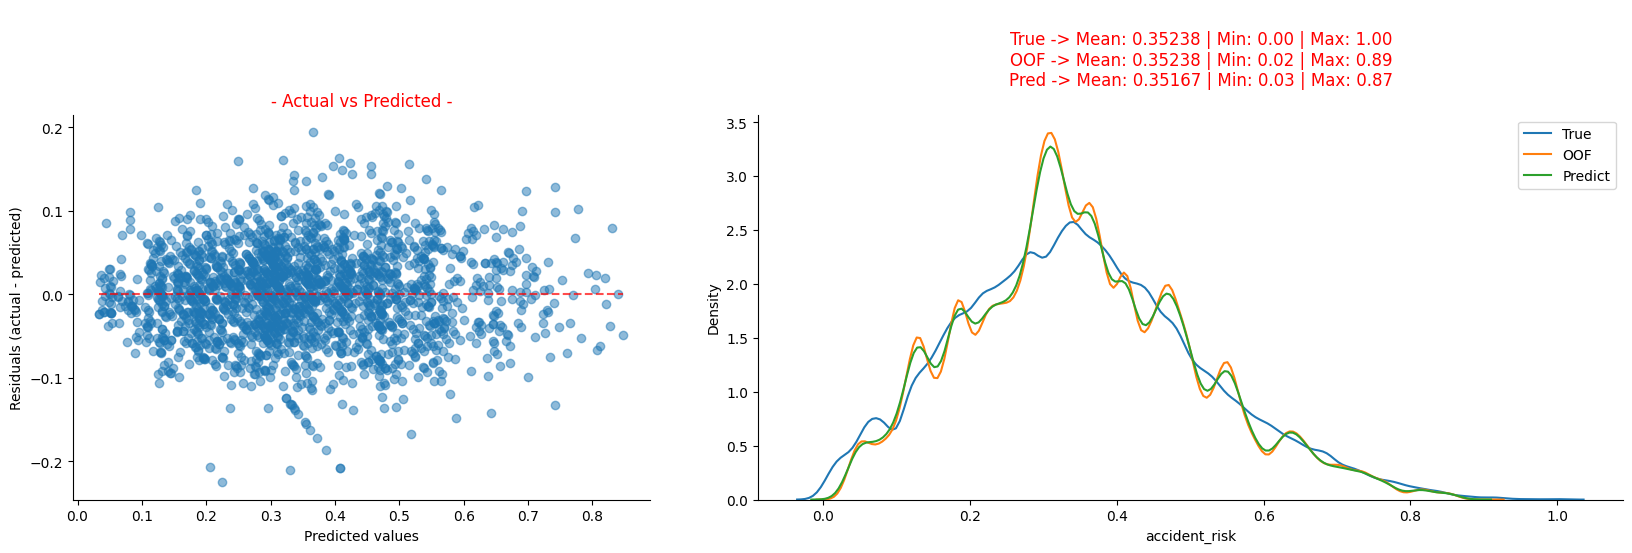

Computation Time: 14773.24 secs ##########################################################################################


In [15]:
## -- DEFINE TRAINING PARAMETERS --
## -----------------------------------------------------------
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true.values, y_pred))

## -- Initiate Training -- ##
oof_preds   = np.zeros(len(train))
test_preds  = np.zeros(len(test))
fold_scores = []

X = train.drop(TARGET, axis=1)
y = train[TARGET]

FOLDS = 10
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

tik = time()
for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"|{'-'*33}")
    print(f"\t{COLOR}Fold {fold} {'#'*5}{RESET}")

    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    X_train_enc = X_train_fold.copy()
    X_val_enc   = X_val_fold.copy()
    test_enc    = test.copy()

    ## -- Target Encoding --
    for col in tqdm(TE, desc="Target Encoding", leave=False):
        if torch.cuda.is_available(): #-> GPU
            TE_enc = cuTE(n_folds=10, smooth=10, split_method='random')
        else: #-> CPU
            TE_enc = ceTE.TargetEncoder(cols=[col], smoothing=0.1)
        n = f"TE_{col}"
        X_train_enc[n] = TE_enc.fit_transform(X_train_enc[col], y_train_fold).astype('float32')
        X_val_enc[n]   = TE_enc.transform(X_val_enc[col]).astype('float32')
        test_enc[n]    = TE_enc.transform(test_enc[col]).astype('float32')

        # X_train_enc = X_train_enc.drop(col, axis=1)
        # X_val_enc   = X_val_enc.drop(col, axis=1)
        # test_enc    = test_enc.drop(col, axis=1)

    ## -- Instantiate model with HPO from optuna -- ##
    params = dict(
                eval_metric = "rmse",
                early_stopping_rounds = 300,
                n_estimators = 10_000,
                eta = 0.005,
                max_depth = 8,
                subsample = 0.9,
                min_child_weight = 5,
                colsample_bytree = 0.25,
                verbosity = 0,
                n_jobs = -1,
                random_state = SEED + fold,
                device = 'cuda',
        )
    model = xgb.XGBRegressor(**params)
    model.fit(
            X_train_enc, y_train_fold,
            eval_set = [(X_val_enc, y_val_fold)],
            verbose  = 100,
        )
    y_fold_pred = model.predict(X_val_enc, iteration_range = (0, model.best_iteration + 1))
    oof_preds[val_idx] = np.clip(y_fold_pred, 0, 1)
    predictions = model.predict(test_enc, iteration_range = (0, model.best_iteration + 1))
    test_preds += np.clip(predictions, 0, 1) / FOLDS

    ## -- Compute RMSE for validation fold
    fold_rmse = rmse(y_val_fold, y_fold_pred)
    fold_scores.append(fold_rmse)
    print(f"\t{COLOR}RMSE Score: {fold_rmse:.6f}{RESET}")

    sleep(2); gc.collect(); sleep(2) # Rest. Clean. Repeat.

## -- After all folds --
overall_score = rmse(y, oof_preds)
print(f"|{'-'*52}")
print(f"{COLOR}|  Overall OOF RMSE: {overall_score:.6f}")
print(f"| Average Fold RMSE: {np.mean(fold_scores):.6f} ± {np.std(fold_scores):.6f}{RESET}")

## -- Plot predictions errors --
fig, axs = plt.subplots(
    1, 2, figsize=(20, 5), gridspec_kw=dict(width_ratios=[0.4, 0.6], wspace=0.15)
)
display = PredictionErrorDisplay.from_predictions(
                y, oof_preds, ax = axs[0],
                # kind = "actual_vs_predicted",
                subsample = 2000,
                scatter_kwargs = {"alpha": 0.5},
                line_kwargs = {'color': 'r'},
        )
axs[0].set_title(f"- Actual vs Predicted -", color='r')
LABELS = ['True', 'OOF', 'Predict']
sns.kdeplot(y, ax=axs[1], label=LABELS[0])
sns.kdeplot(oof_preds, ax=axs[1], label=LABELS[1])
sns.kdeplot(test_preds, ax=axs[1], label=LABELS[2])
axs[1].set_title(f"""
    True -> Mean: {np.mean(y):.5f} | Min: {np.min(y):.2f} | Max: {np.max(y):.2f}
    OOF -> Mean: {np.mean(oof_preds):.5f} | Min: {np.min(oof_preds):.2f} | Max: {np.max(oof_preds):.2f}
    Pred -> Mean: {np.mean(test_preds):.5f} | Min: {np.min(test_preds):.2f} | Max: {np.max(test_preds):.2f}
        """, color='r')

for ax in axs:
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.legend()
plt.tight_layout()
plt.show()

name = f"xgb" + f"{overall_score:.6f}".split('.')[1]
oof_final  = pd.DataFrame(oof_preds, columns=[name])
test_final = pd.DataFrame(test_preds, columns=[name])

tok = time()
tiktok = tok-tik
print(f"Computation Time: {tiktok:.2f} secs {'#'*90}")

In [16]:
## -- Save OOF & PREDICTIONS --
oof_final.to_parquet(f"{name}_oof.parquet", index=False)
test_final.to_parquet(f"{name}_pred.parquet", index=False)

## -- Submission file --
submit[TARGET] = test_final.values
submit.to_csv(f"submit_{name}.csv", index=False)
submit.head()

,id,accident_risk
0,517754,0.295513
1,517755,0.122125
2,517756,0.178253
3,517757,0.313555
4,517758,0.393049


In [17]:
X_val_enc.shape

(51775, 539)

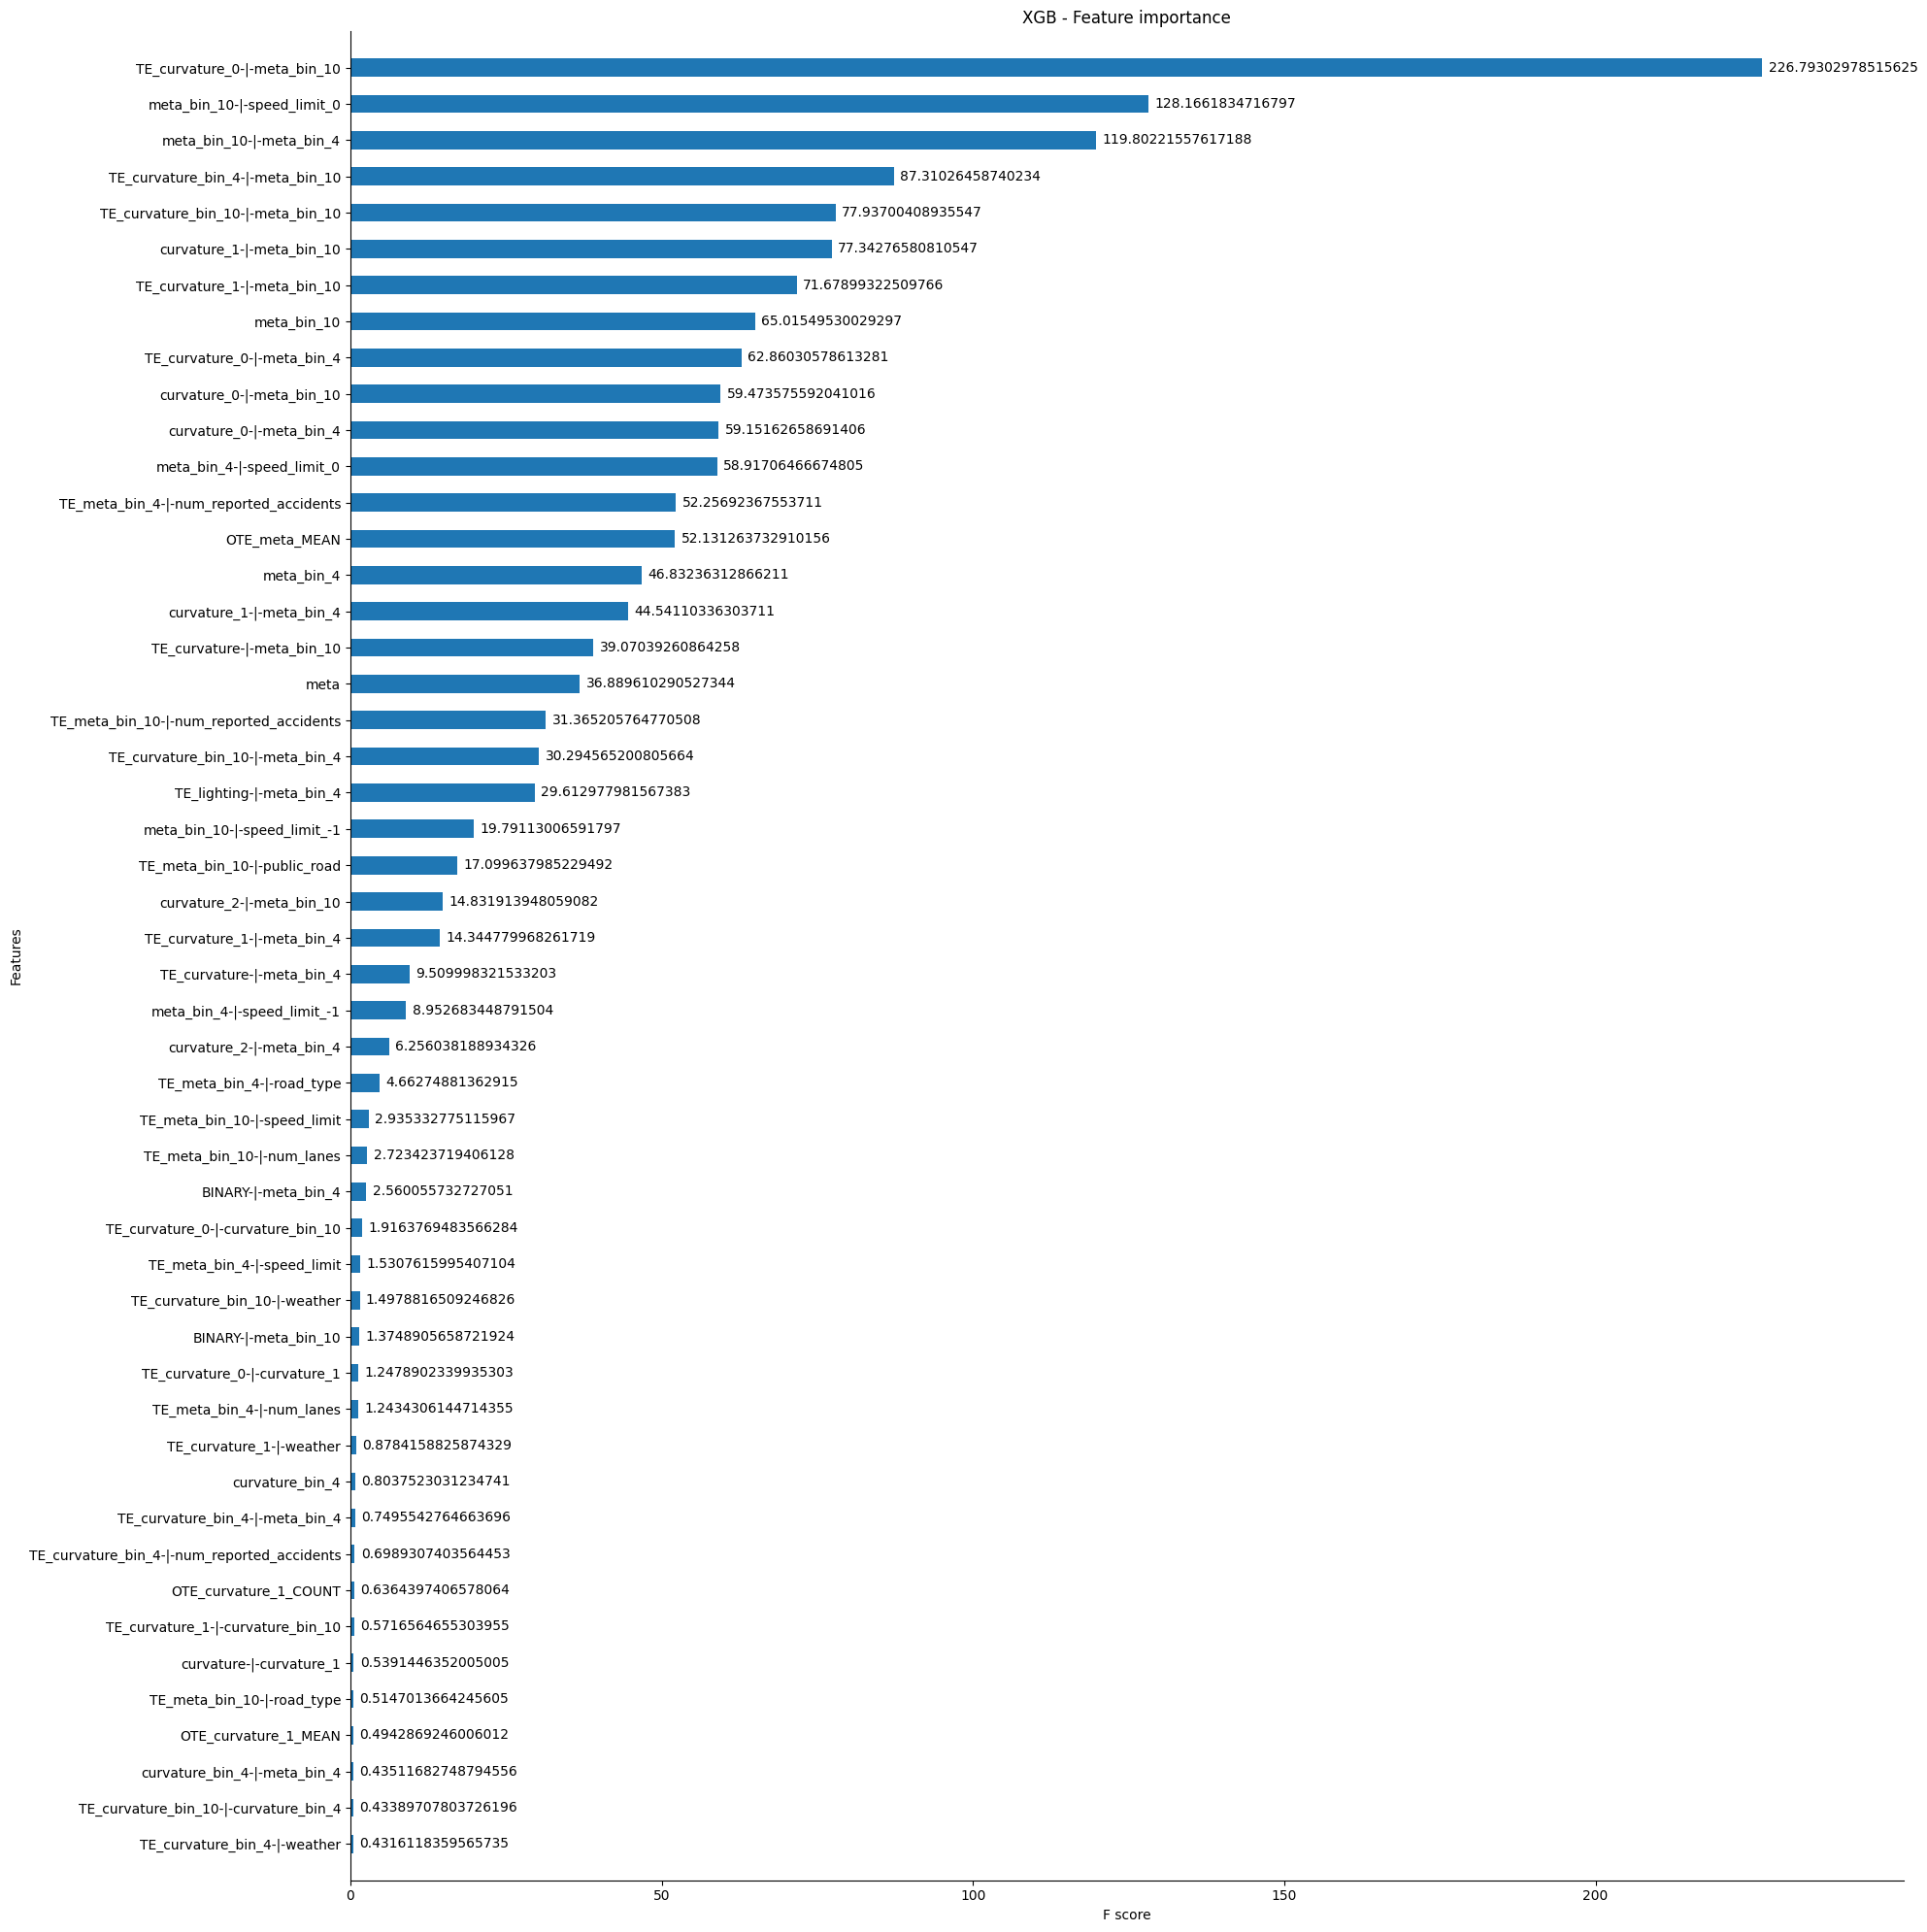

In [18]:
## -- Plot Feature Importances --
MAX = 50
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
xgb.plot_importance(
                    model, ax=ax,
                    importance_type='gain',
                    grid=False, height=0.5,
                    # show_values=False,
                    max_num_features=MAX,
                    title="XGB - Feature importance"
    )
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

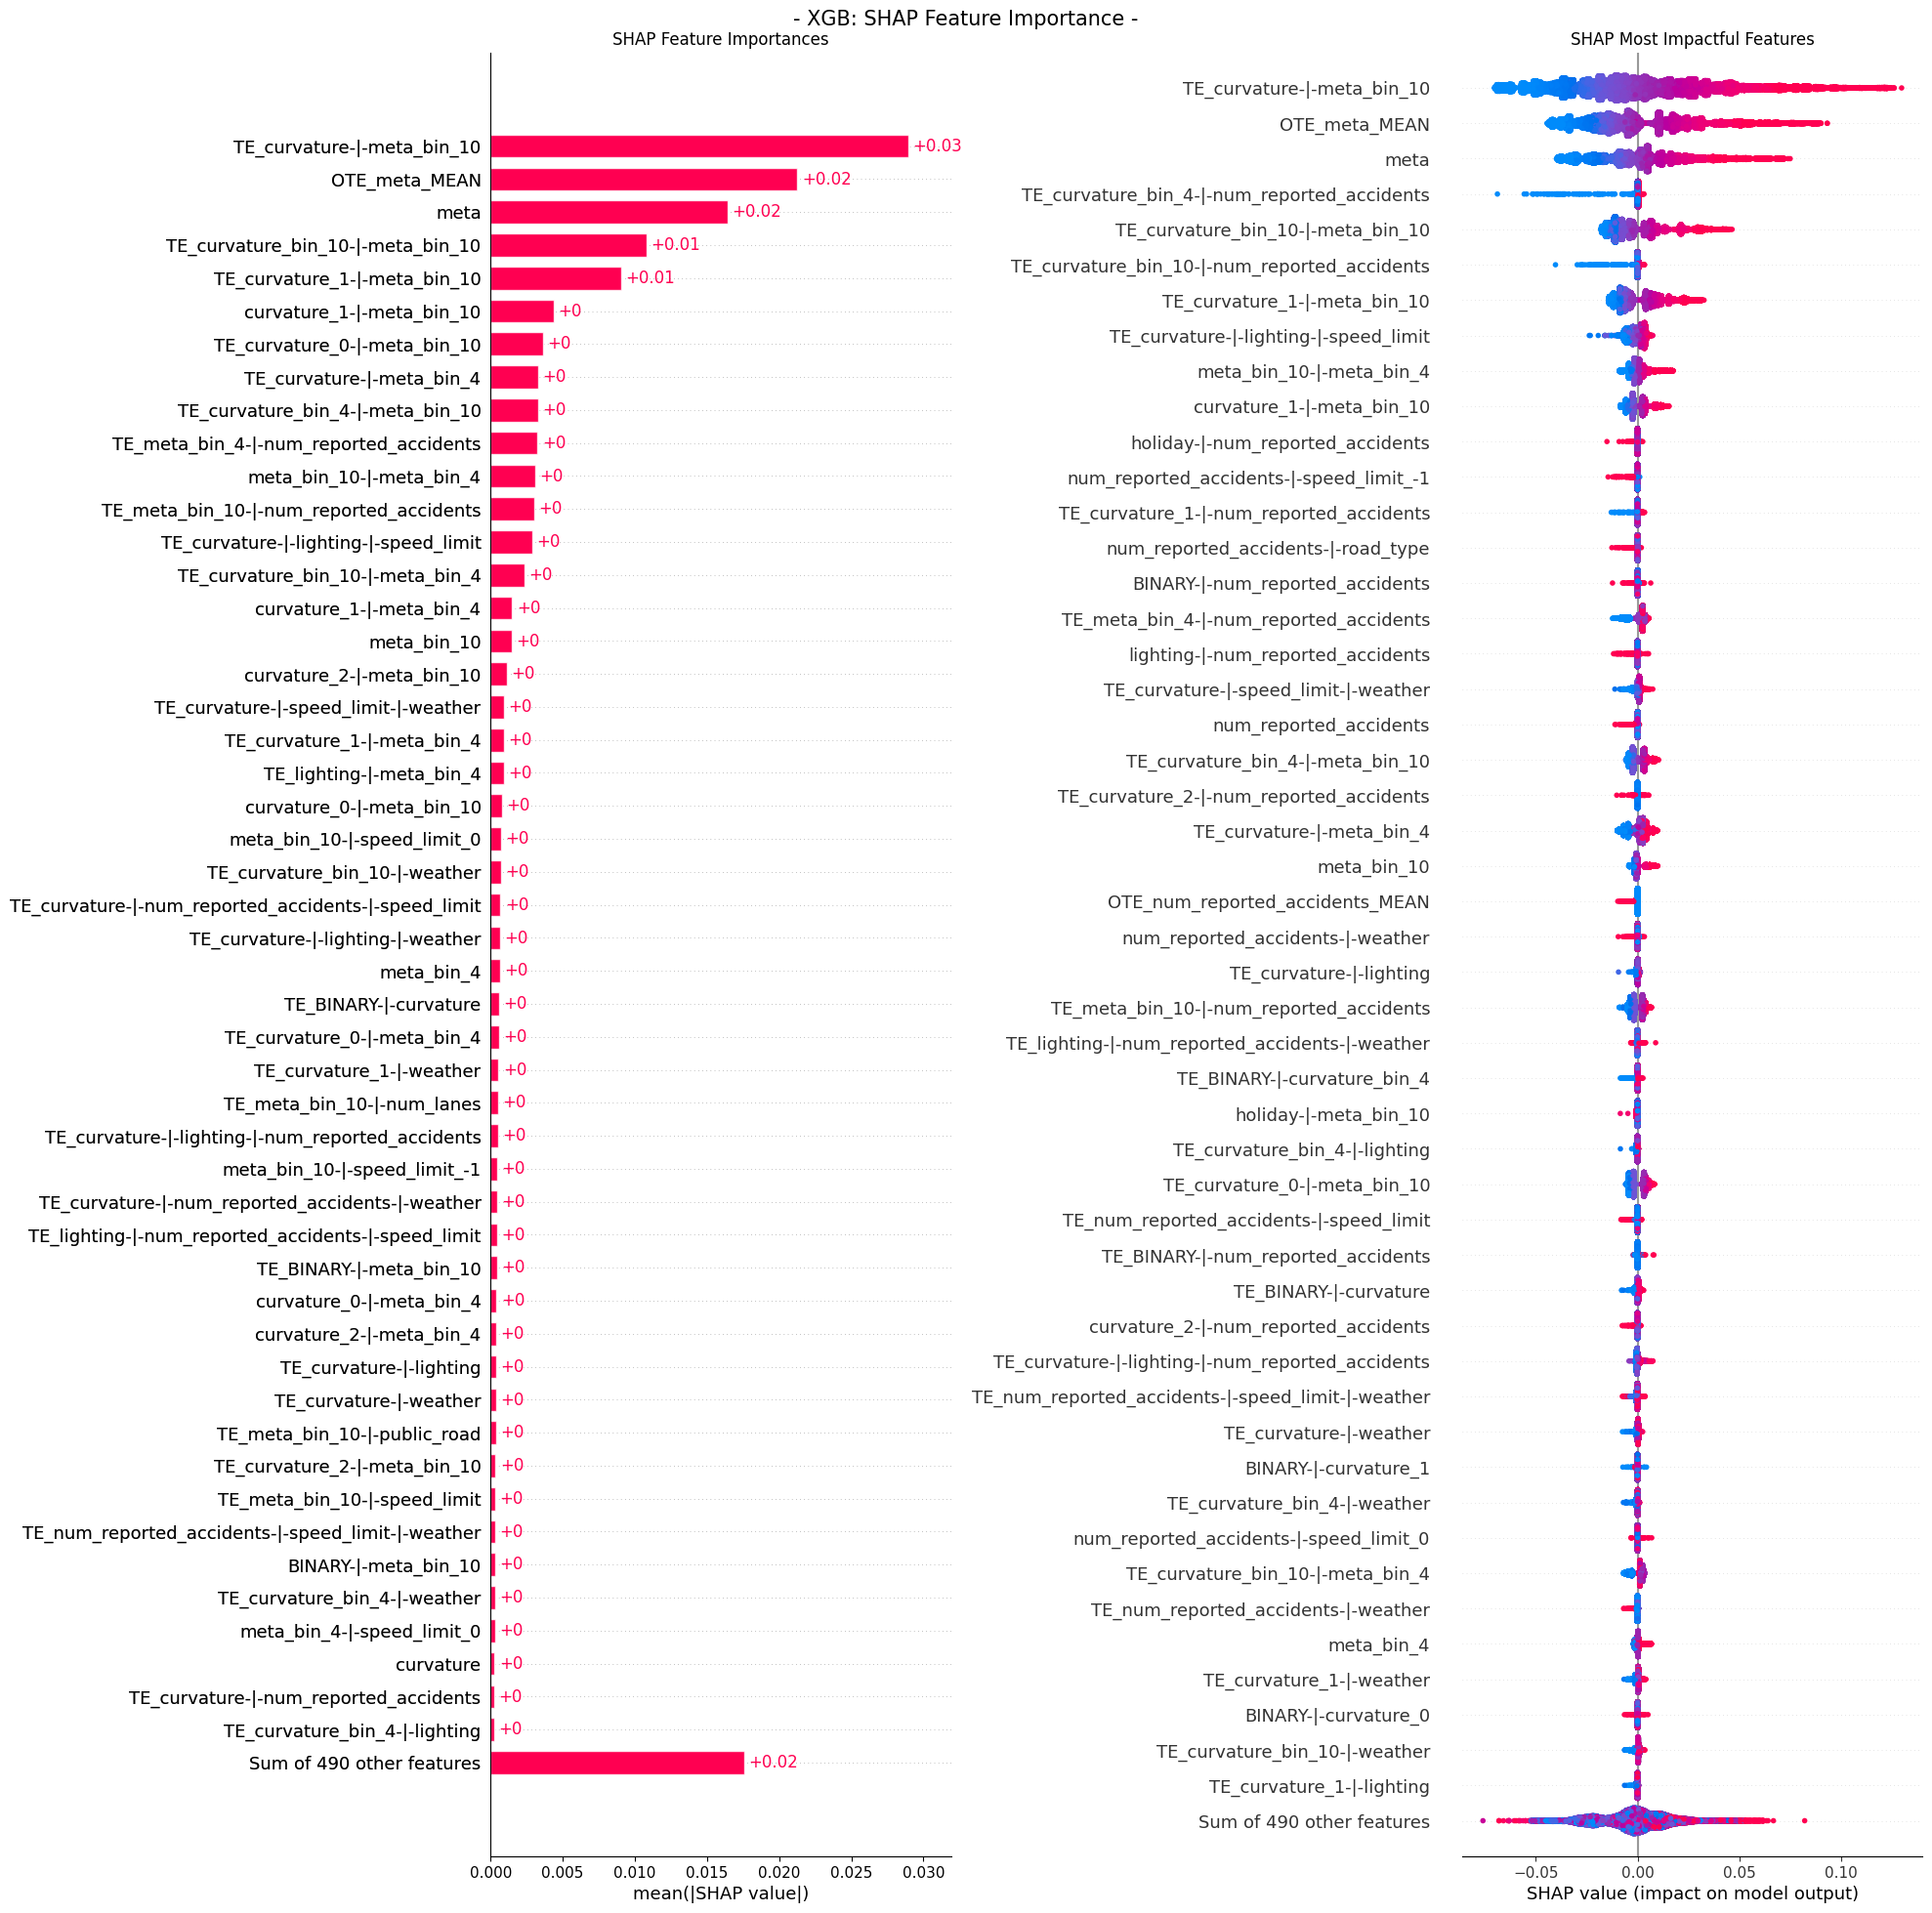

In [19]:
## -- Plot SHAP --
fig, axs =  plt.subplots(1, 2, figsize=(20, 20))

explainer = shap.TreeExplainer(model)
explanation = explainer(X_val_enc)
# shap_values has outputs .values, .base_values, .data

# Bar plot
shap.plots.bar(explanation, show=False, max_display=MAX, ax=axs[0])
axs[0].set_title("SHAP Feature Importances")
# Beeswarm plot
shap.plots.beeswarm(explanation, show=False, max_display=MAX, ax=axs[1],
                    order=explanation.abs.max(0),
                    color_bar=False, plot_size=None)
axs[1].set_title("SHAP Most Impactful Features")
fig.suptitle(f"- XGB: SHAP Feature Importance -", fontsize=15)
fig.tight_layout(pad=1.5)
plt.show()

In [20]:
# @title
# ## -- GPU FORWARD FEATURE SELECTION -- ##
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

# ADD  = []
# best_rmse = 0
# best_oof = None
# best_pred = None

# FOLDS = 5
# kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# X = train.drop(TARGET, axis=1)
# y = train[TARGET]

# # FORWARD FEATURE SELECTION
# for k, col in enumerate(['baseline']+TE_columns, start=1):
#     oof_cuRF = np.zeros(len(X))
#     pred_cuRF = np.zeros(len(test))
#     # scaler = RobustScaler()
#     encoder = ce.TargetEncoder(cols=col, smoothing=10)

#     if col != 'baseline': ADD.append(col)

#     # K-FOLD USING YEAR AS GROUP
#     for i, (train_index, test_index) in enumerate(kf.split(X)):
#         # TRAIN AND VALID DATA
#         x_train = X.loc[train_index, ['TrackDurationMs']+ADD].copy()
#         y_train = y.loc[train_index]
#         x_valid = X.loc[test_index, ['TrackDurationMs']+ADD].copy()
#         y_valid = y.loc[test_index]
#         x_test = test[['TrackDurationMs']+ADD].copy()

#         # x_train = scaler.fit_transform(x_train)
#         # x_valid = scaler.transform(x_valid)

#         if col != 'baseline':
#             encoder.fit(x_train, y_train)
#             x_train = encoder.transform(x_train)
#             x_valid = encoder.transform(x_valid)

#         # # SVC WANTS STANDARIZED FEATURES
#         # for c in ORIG_FEATURES+ADD:
#         #     m = x_train[c].mean()
#         #     s = x_train[c].std()
#         #     x_train[c] = (x_train[c]#-m)/s
#         #     x_valid[c] = (x_valid[c]#-m)/s
#         #     x_test[c] = (x_test[c]#-m)/s
#         #     x_test[c] = x_test[c]#.fillna(0)

#         # TRAIN SVC MODEL
#         # model = RandomForestClassifier()
#         model = xgb.XGBRegressor(random_state=SEED, device=USE_cud, n_estimators=200)
#         model.fit(x_train.values, y_train.values)

#         # INFER OOF
#         oof_cuRF[test_index] = model.predict(x_valid.values)
#         # INFER TEST
#         pred_cuRF += model.predict(x_test.values)

#     gc.collect()

#     # COMPUTE AVERAGE TEST PREDS
#     pred_cuRF /= FOLDS

#     # COMPUTE CV VALIDATION AUC SCORE
#     # true = y.values
#     m = rmse(y.values, oof_cuRF)

#     if m<best_rmse:
#         print(f"{k}. \033[32m ❇️ NEW_ BEST with {col} at {m:.6f}{RESET}")
#         best_auc = m
#         best_oof = oof_cuRF.copy()
#         best_pred = pred_cuRF.copy()
#     else:
#         print(f"{k}. \033[31m 🔻 NEW_WORSE with {col} at {m:.6f}{RESET}")
#         ADD.remove(col)